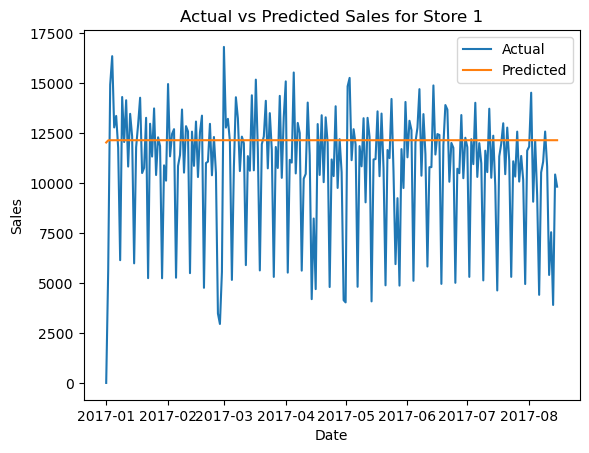

In [15]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Load the data
# Load the data
zf = zipfile.ZipFile('train.csv.zip') 
data = pd.read_csv(zf.open('train.csv'))

# Convert the date column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Aggregate the sales data by store
store_data = data.groupby(['store_nbr', 'date'])['sales'].sum().reset_index()

# Select data for store 1
store_1_data = store_data[store_data['store_nbr'] == 1]

# Divide the data into training and testing sets
train_data = store_1_data[store_1_data['date'] < '2017-01-01']
test_data = store_1_data[store_1_data['date'] >= '2017-01-01']
# Fit the ARIMA model to the training data using the determined values of p, d, and q
model = ARIMA(train_data['sales'], order=(1,1,1))
model_fit = model.fit()

# Use the model to forecast sales for the test data
y_pred = model_fit.forecast(len(test_data))

# Plot actual vs predicted sales
plt.plot(test_data['date'], test_data['sales'], label='Actual')
plt.plot(test_data['date'], y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales for Store 1')
plt.legend()
plt.show()


In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error

In [25]:
!pip install pmdarima

     -------------------------------------- 572.7/572.7 kB 3.6 MB/s eta 0:00:00


In [27]:
zf = zipfile.ZipFile('train.csv.zip') 
train_df = pd.read_csv(zf.open('train.csv'))

In [29]:
oil = pd.read_csv('oil.csv')
store = pd.read_csv('stores.csv')
holidays_events = pd.read_csv('holidays_events.csv')

In [30]:
data_train_choice = train_df[train_df['store_nbr'] == 1].copy()
store_choice = store[store['store_nbr'] == 1].copy()

In [31]:
data_train_choice['date'] = pd.to_datetime(data_train_choice['date'])

In [32]:
print("Rows: ", data_train_choice.shape)
print("Remove duplicates rows:", data_train_choice.drop_duplicates().shape)

Rows:  (55572, 6)
Remove duplicates rows: (55572, 6)


In [33]:
data_train_choice = data_train_choice.groupby('date')[['sales','onpromotion']].sum().reset_index()

In [35]:
dates = pd.date_range(start=min(data_train_choice['date']),end=max(data_train_choice['date']))
dates = pd.DataFrame(dates, columns=['date'])
data_train_choice = dates.merge(data_train_choice,on='date',how='left')

In [36]:
data_train_choice.fillna(0,inplace=True)

In [37]:
index_events_trasnferred = holidays_events[holidays_events['transferred']].index

In [38]:
holidays_events.drop(index_events_trasnferred, axis=0, inplace=True)

In [39]:
store_choice

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13


In [40]:
holidays_events = holidays_events[(holidays_events['locale_name'] == 'Quito') | (holidays_events['locale'] == 'National')]

In [41]:
oil['date'] = pd.to_datetime(oil['date'] )

In [42]:
oil.isna().mean()

date          0.000000
dcoilwtico    0.035304
dtype: float64

In [43]:
oil.fillna(oil.shift(1),inplace=True)

In [44]:
data_train_choice['holiday'] = np.where(data_train_choice['date'].isin(holidays_events['date']),1,0)
data_train_choice = data_train_choice.merge(oil, on='date',how='left')

In [45]:
data_train_choice['dcoilwtico'] = data_train_choice['dcoilwtico'].fillna(data_train_choice['dcoilwtico'].shift(1))
data_train_choice['dcoilwtico'] = data_train_choice['dcoilwtico'].fillna(data_train_choice['dcoilwtico'].shift(1))

In [46]:
train_size = 0.70
X_train = data_train_choice.loc[0:np.round(data_train_choice.shape[0]*train_size),:]
X_test = data_train_choice.loc[np.round(data_train_choice.shape[0]*train_size):,:]
X_train = X_train.set_index('date').asfreq('d')
X_test = X_test.set_index('date').asfreq('d')

In [47]:
def plot_ts_decompose(decompose,figsize=(12,8)):
    fig, ax = plt.subplots(4,1,figsize=figsize)
    sns.lineplot(data = decompose.observed, x = decompose.observed.index, y = decompose.observed,ax=ax[0])
    sns.lineplot(data = decompose.trend, x = decompose.trend.index, y = decompose.trend,ax=ax[1])
    sns.lineplot(data = decompose.seasonal ,x = decompose.seasonal.index, y = decompose.seasonal,ax=ax[2])
    sns.lineplot(data = decompose.resid ,x = decompose.resid.index, y = decompose.resid,ax=ax[3])
    plt.tight_layout()

In [48]:
decompose = seasonal_decompose(X_train['sales'],model='additive')

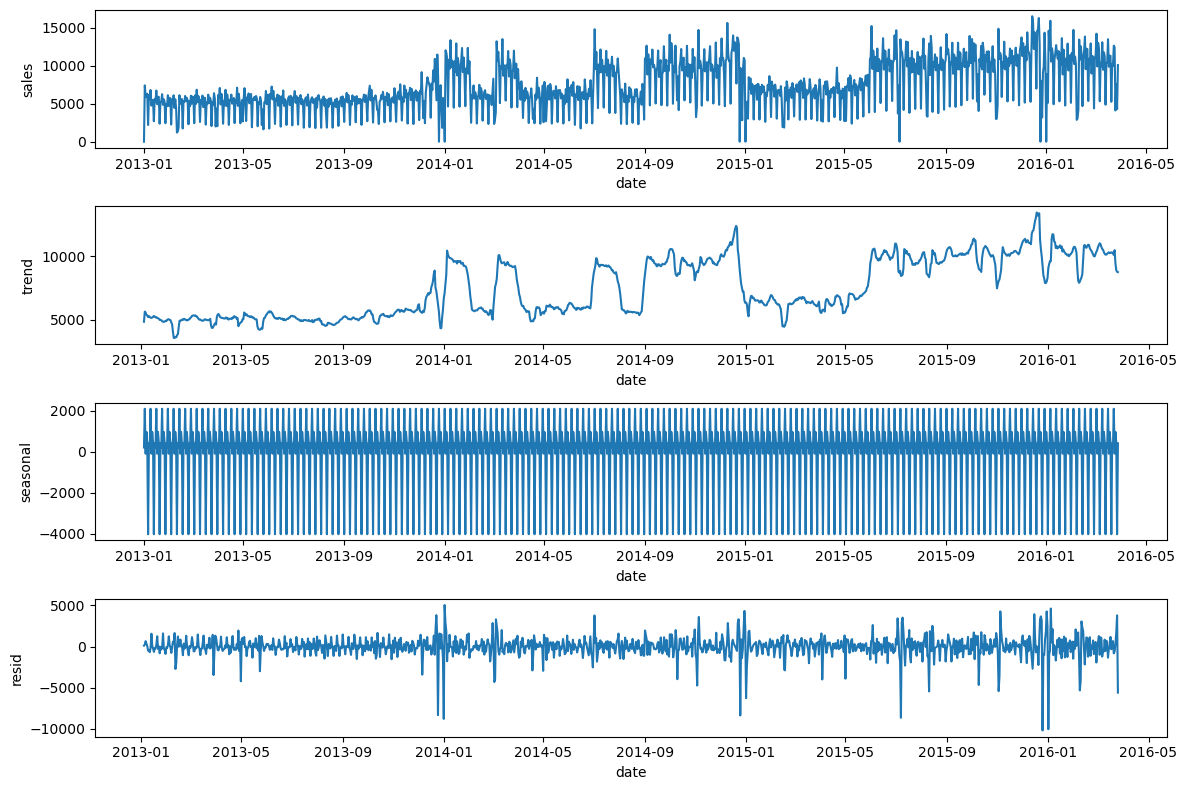

In [49]:
plot_ts_decompose(decompose)

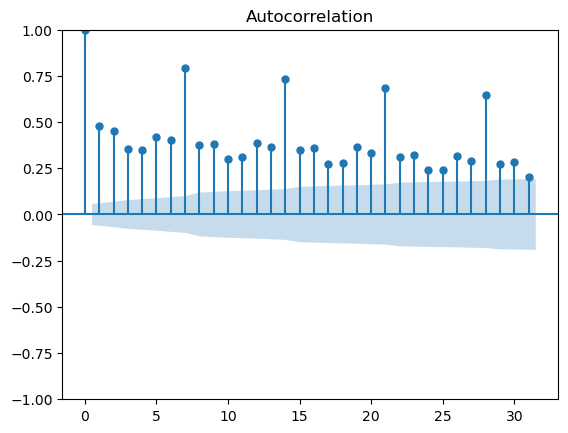

In [50]:
plot_acf(X_train['sales'], alpha = 0.05);

C:\Users\dathr\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


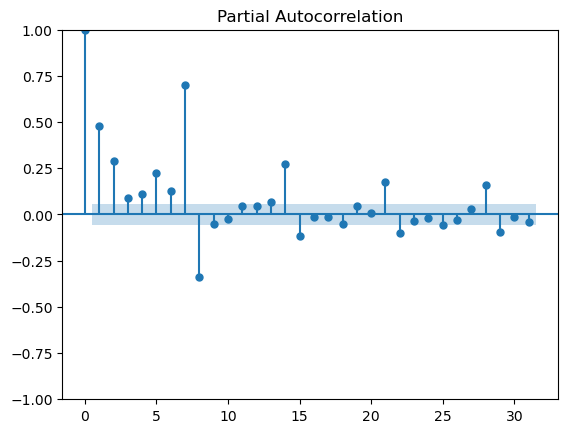

In [52]:
plot_pacf(X_train['sales'], alpha = 0.05);

 we can see, we have a seasonal pattern on day 5,6 and 15, 16, that is, for every 5 days we have an increase in sales.

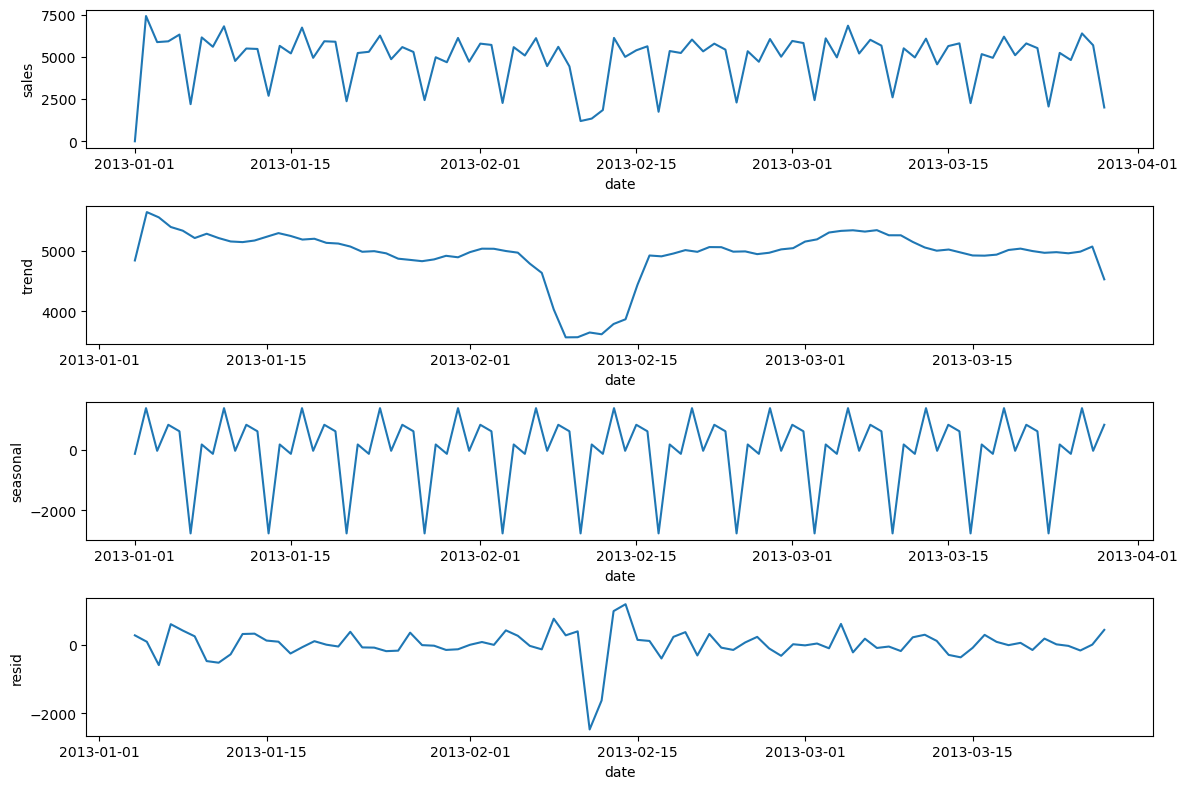

In [53]:
decompose = seasonal_decompose(X_train[X_train.index < '2013-03-30']['sales'],model='additive')
plot_ts_decompose(decompose)

In [54]:
p_value_adfuller = adfuller(X_train['sales'])[1]
print(p_value_adfuller)

0.10618430721827615


In [55]:
X_train['diff_sales'] = X_train['sales'].diff()

7.44265782633121e-18


C:\Users\dathr\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


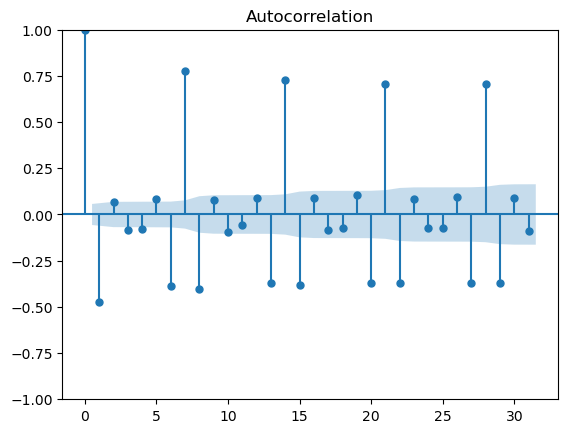

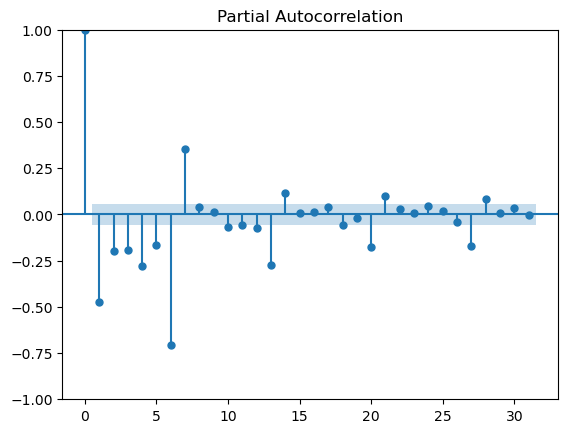

In [56]:
p_value_adfuller = adfuller(X_train['diff_sales'].dropna())[1]
print(p_value_adfuller)
plot_acf(X_train['diff_sales'].dropna(), alpha = 0.05);
plot_pacf(X_train['diff_sales'].dropna(), alpha = 0.05);

In [57]:
X_train['diff_onpromotion'] =  X_train['onpromotion'].diff()
X_train['diff_dcoilwtico'] =  X_train['dcoilwtico'].diff()

In [58]:
X_test['diff_onpromotion'] =  X_test['onpromotion'].diff()
X_test['diff_sales'] =  X_test['sales'].diff()

In [59]:
arima_train = X_train.dropna().copy()
model_arima = ARIMA(arima_train['diff_sales'],freq='D', exog=arima_train[['diff_onpromotion','holiday']], order=(6,0,2))
result = model_arima.fit(method_kwargs={"warn_convergence": False})

print(result.summary())

                               SARIMAX Results                                
Dep. Variable:             diff_sales   No. Observations:                 1181
Model:                 ARIMA(6, 0, 2)   Log Likelihood              -10420.825
Date:                Thu, 13 Apr 2023   AIC                          20865.649
Time:                        14:28:00   BIC                          20926.538
Sample:                    01-03-2013   HQIC                         20888.604
                         - 03-28-2016                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              102.4421     25.721      3.983      0.000      52.030     152.854
diff_onpromotion    28.4309      1.705     16.678      0.000      25.090      31.772
holiday          -1337.5359 

4.070212291130973e-06


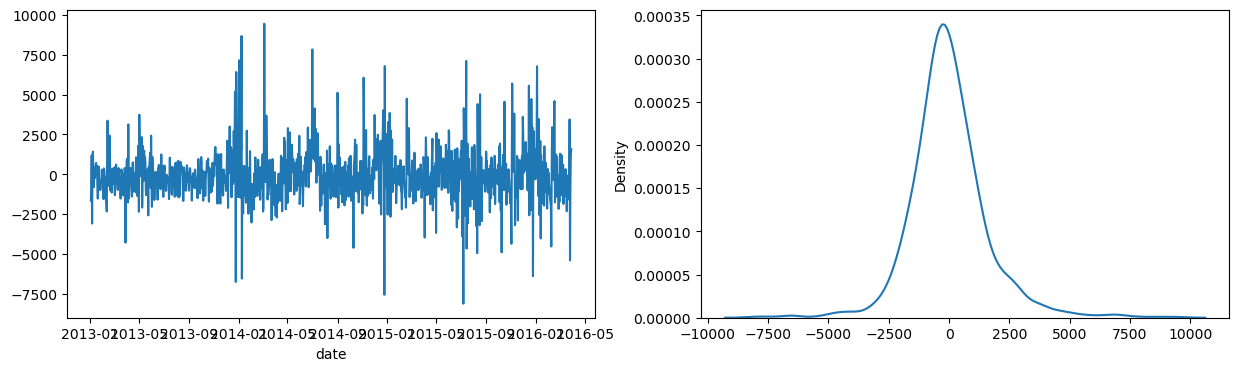

In [60]:
fig, ax = plt.subplots(1,2,figsize=(15,4))
sns.lineplot(x=result.resid.index, y=result.resid.values,ax=ax[0])
sns.kdeplot(x=result.resid.values,ax=ax[1])
print(adfuller(result.resid)[1])

In [62]:
arima_test =  X_test.dropna()

In [63]:
predict_arima = result.predict(start = min(arima_test.index), end = max(arima_test.index), exog = arima_test[['diff_onpromotion','holiday']])

3429.740163226556


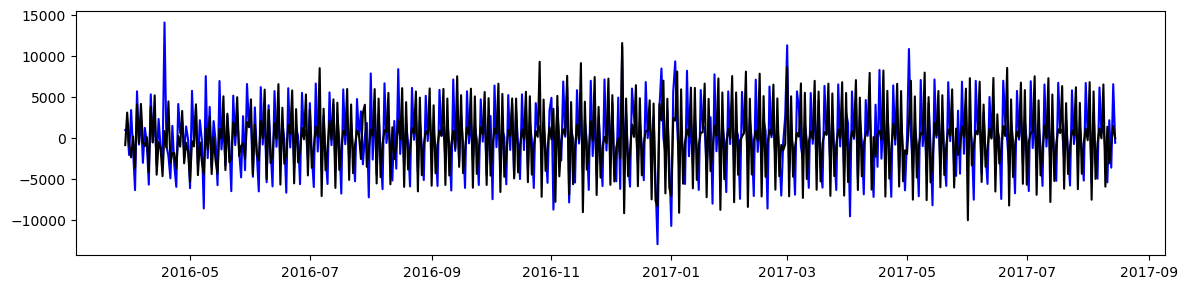

In [65]:
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(arima_test.index, arima_test['diff_sales'], color='blue')
ax.plot(arima_test.index, predict_arima, color='black')
plt.tight_layout()
print(mean_absolute_error(arima_test['diff_sales'], predict_arima))

In [66]:
X_test

,sales,onpromotion,holiday,dcoilwtico,diff_onpromotion,diff_sales
date,,,,,,
2016-03-28,10090.241000,58.0,0,37.99,NaN,NaN
2016-03-29,11029.380000,56.0,0,36.91,-2.0,939.139000
2016-03-30,12195.649000,275.0,0,36.91,219.0,1166.269000
2016-03-31,10097.373000,57.0,0,36.94,-218.0,-2098.276000
2016-04-01,13478.620000,239.0,0,35.36,182.0,3381.247000
...,...,...,...,...,...,...
2017-08-11,5403.742021,216.0,1,48.81,91.0,-5430.836979
2017-08-12,7543.623000,103.0,0,48.81,-113.0,2139.880979
2017-08-13,3902.782000,73.0,0,48.81,-30.0,-3640.841000


In [68]:
predict_arima

2016-03-29    -888.838243
2016-03-30    3071.007081
2016-03-31    -699.143771
2016-04-01   -2378.461479
2016-04-02     167.593201
                 ...     
2017-08-11    1350.686918
2017-08-12   -3109.316918
2017-08-13    -750.746840
2017-08-14    1438.260630
2017-08-15     -38.692696
Freq: D, Name: predicted_mean, Length: 505, dtype: float64

In [69]:
model_auto_arima = auto_arima(arima_train['diff_sales'],freq='D', exog=arima_train[['diff_onpromotion','holiday']])

In [70]:
print(model_auto_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1181
Model:               SARIMAX(2, 0, 5)   Log Likelihood              -10733.296
Date:                Thu, 13 Apr 2023   AIC                          21482.591
Time:                        14:32:00   BIC                          21523.184
Sample:                    01-03-2013   HQIC                         21497.895
                         - 03-28-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8006      0.002   -818.420      0.000      -1.805      -1.796
ar.L2         -0.9989      0.002   -475.517      0.000      -1.003      -0.995
ma.L1          1.3500      0.044     30.907      0.0

In [71]:
predict_autoarima = model_auto_arima.predict(n_periods = len(arima_test) , index = arima_test.index)

2664.305354370321


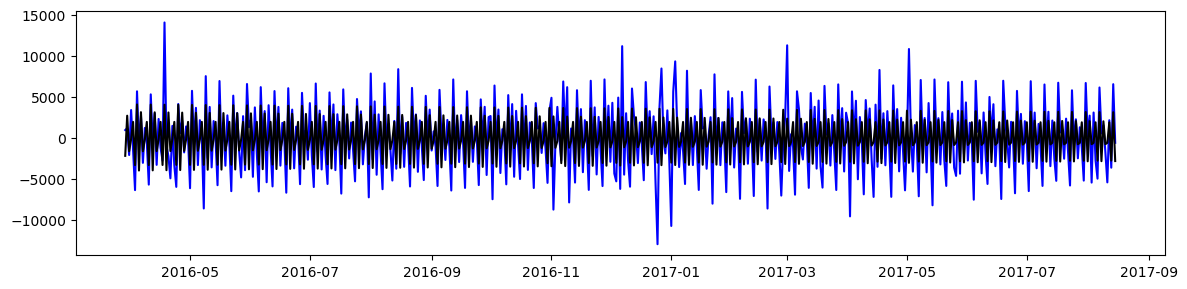

In [72]:
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(arima_test.index, arima_test['diff_sales'], color='blue')
ax.plot(arima_test.index, predict_autoarima, color='black')
plt.tight_layout()
print(mean_absolute_error(arima_test['diff_sales'], predict_autoarima)**0.5)